# Lab 6: PCA

## Data 88 - Data Science in Genetics and Genomics, 03/30/20
## Due Monday, 04/06/20 @ 11:59 PM

## by Jonathan Fischer

In [1]:
# Load the modules we'll need
from datascience import *
import numpy as np
import random
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.stats as stats
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_spd_matrix
plt.style.use('fivethirtyeight')
#from client.api.notebook import Notebook

PCA finds a good way to summarize your data using fewer dimensions than you started with. The covariance (aka the "shape") of your data dictates how easily it can do this. Data with highly correlated features has many redundancies and can thus be represented by fewer dimensions more easily. Let's examine two examples of the utility of PCA when analyzing sequencing data.

# PCA on genotype data

We'll start with an example of using PCA to help distguingish among individuals with various ancestries. The original data come from the HapMap consortium and consisted of SNP readings from a genotyping array along with a description of the population of the individual whose genotype has been measured. I've processed these data to only look at chromosome 22 (for computational purposes) and to convert each entry to a 0, 1, or 2. This number indicates the number of mutant alleles at a particular locus. In this case you can just think of this as counting how often an individual had the allele that is rarer in the overall population at a given site.

In [2]:
# Load the genotype information and population labels
geno_mat = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab06/chr22_all_genotypes.csv')
pop_labs = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab06/HapMap_pop_labels.csv')

In [3]:
# Rows are loci, columns are individuals
print('We are using ' + str(geno_mat.shape[0]) + ' loci to examine ' + str(geno_mat.shape[1]) + ' individuals from ' + str(len(np.unique(pop_labs))) + ' labeled populations.')
      
geno_mat.iloc[0:10, 0:10]

We are using 20047 loci to examine 867 individuals from 9 labeled populations.


,NA19909,NA19908,NA19901,NA19900,NA20127,NA20126,NA20357,NA20356,NA19704,NA19703
0,2,0,0,1,2,1,0,0,0,1
1,0,1,1,0,0,0,1,1,0,2
2,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0
4,0,2,2,1,0,0,1,0,2,2
5,0,0,0,0,0,0,0,0,0,0
6,1,1,0,1,0,0,1,1,1,0
7,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,1,0,0,0
9,1,0,1,0,0,0,1,0,0,0


Here you can see how the population labels look. The cell below the table shows the different populations which are being considered in the experiment. They span Europe, Asia, and Africa.

In [4]:
pop_labs.T

,0,1,2,3,4,5,6,7,8,9,...,857,858,859,860,861,862,863,864,865,866
pop,asw,asw,asw,asw,asw,asw,asw,asw,asw,asw,...,yri,yri,yri,yri,yri,yri,yri,yri,yri,yri


ASW - African ancestry in Southwest USA<br/>
CEU - Utah residents with Northern and Western European ancestry<br/>
CHD - Chinese in Denver<br/>
GIH - Gujarati Indians in Houston<br/>
JPT_CHB - Japanese in Tokyo and Chinese in Beijing<br/>
MEX - Mexican ancestry in Los Angeles<br/>
MKK - Maasai in Kinyawa, Kenya<br/>
TSI - Toscani in Italy<br/>
YRI - Yoruba in Ibadan, Nigeria

Let's apply PCA to these data and see whether individuals with ancestry from the same or geographically proximate populations cluster near one another. We start by standardizing our matrix and running the PCA algorithm. Standardizing consists of subtracting the column mean from each column and then dividing by the standard deviation of that column. This step isn't always necessary, but often helps for reasons I'll only briefly touch on here.

First, it removes the mean which could potentially dominate our signal (see this post https://stats.stackexchange.com/questions/22329/how-does-centering-the-data-get-rid-of-the-intercept-in-regression-and-pca). Subtraction of the mean is called "centering" our data. Second, it puts all variables on the same scale such that quantities with naturally higher variances don't dominate (this is "scaling"). Depending on your data, the scaling step may or may not be a good idea. It's a bit of an art and knowing what to do will come with experience. For now we'll go ahead and scale. This link (https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html) shows what can happen if we don't scale.

In [5]:
# compute column means and standard deviations
geno_means = np.mean(geno_mat, axis = 1)
geno_sds = np.std(geno_mat, axis = 1)

# standardize the matrix
y = (geno_mat.T - geno_means) / geno_sds

# run PCA with 100 components
geno_pca = PCA(n_components=100)
geno_pca.fit(y.T)
geno_comps = geno_pca.components_

A good diagnostic to perform after running PCA is to take a look at the singular values to see how successfully your data were able to be summarized with fewer dimensions. These singular values essentially tell us how important the corresponding principal component is in summarizing our data. Here we find a pretty steep drop-off after the first two singular values, meaning our data can be well-described using only two dimensions. How convenient for plotting!<br/>
These singular values can be converted to something more intuitive, the proportion of variation explained. These values tell us how much of the total variation in our data were captured by each respective principal component. In this case, we see the top PC captures 8-9% of the total variation.

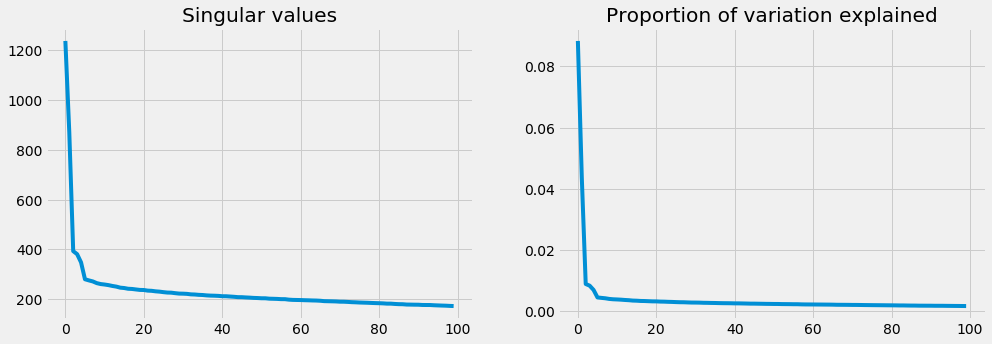

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(geno_pca.singular_values_)
plt.title('Singular values')
plt.subplot(122)
plt.plot(geno_pca.explained_variance_ratio_)
plt.title('Proportion of variation explained')
plt.show()

Now let's take a look at the projection of our data to 2 dimensions. Remember that our original data consisted of over 20k genes, and we're trying to condense all of this information down to effectively 2 "new genes."

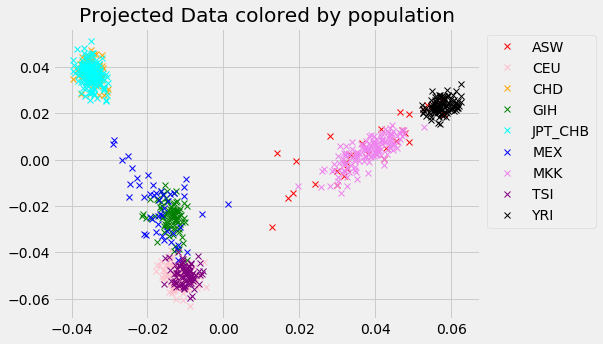

In [7]:
# Plot the projections using the first 2 PCs. Color the points by population labels
i = 0
j = 1
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(geno_comps[i, pop_labs['pop'] == 'asw'], geno_comps[j, pop_labs['pop'] == 'asw'], 'x', c = 'red')
plt.plot(geno_comps[i, pop_labs['pop'] == 'ceu'], geno_comps[j, pop_labs['pop'] == 'ceu'], 'x', c = 'pink')
plt.plot(geno_comps[i, pop_labs['pop'] == 'chd'], geno_comps[j, pop_labs['pop'] == 'chd'], 'x', c = 'orange')
plt.plot(geno_comps[i, pop_labs['pop'] == 'gih'], geno_comps[j, pop_labs['pop'] == 'gih'], 'x', c = 'green')
plt.plot(geno_comps[i, pop_labs['pop'] == 'jpt_chb'], geno_comps[j, pop_labs['pop'] == 'jpt_chb'], 'x', c = 'cyan')
plt.plot(geno_comps[i, pop_labs['pop'] == 'mex'], geno_comps[j, pop_labs['pop'] == 'mex'], 'x', c = 'blue')
plt.plot(geno_comps[i, pop_labs['pop'] == 'mkk'], geno_comps[j, pop_labs['pop'] == 'mkk'], 'x', c = 'violet')
plt.plot(geno_comps[i, pop_labs['pop'] == 'tsi'], geno_comps[j, pop_labs['pop'] == 'tsi'], 'x', c = 'purple')
plt.plot(geno_comps[i, pop_labs['pop'] == 'yri'], geno_comps[j, pop_labs['pop'] == 'yri'], 'x', c = 'black')

plt.legend(['ASW', 'CEU', 'CHD', 'GIH', 'JPT_CHB', 'MEX', 'MKK', 'TSI', 'YRI'], loc = 'upper left', bbox_to_anchor = (1,1))
plt.title('Projected Data colored by population')
plt.show()

## Questions for this section

### A1. Can you see evidence of the presence of different continents in the figure? If so, how?

Yes, there seem to be clusters of Europeans (bottom), East Asians (upper left) and Africans (upper right).

### A2. A handful of the populations roughly overlap one another in the figure. Which ones make sense to you, and which ones do not?

The TSI/CEU and JPT_CHB/CHD clusters make sense because they consist of European and East Asians, respectively. The MEX/GIH overlap is more surprising since Mexico and India are very far apart geographically.

### A3. A few of the populations seem to lie between apparent "endpoints" in the figure. Do you have any theories for why this might be the case?

The ASW group is between the European and native African groups, probably indicative of the admixture that is prevalent among African-Americans. Similarly, the MEX group is likely admixed between Europeans and Native Americans, who are genetically very similar to East Asians. The placement of the GIH group could demonstrate similar admixture or migratory patterns, though it's harder to be certain.

### A4. The original figure displayed above only shows the results of comparing the first two principal components. To instead compare PCs 2 and 3, change "i = 0" to "i = 2" and re-generate the figure. Do any of the previously overlapping population groups which surprised you now show better separation? What does this imply about the information contained by PCs 1 and 3?

Yes, the MEX and GIH no longer overlap one another. This implies that PCs 1 and 3 capture fundamentally different genetic information, which makes sense given how PCA constructs orthogonal components.

### A5. From what you've learned about PCA, how would you explain the fact that different population groups seem to occupy different amounts of space in the figure?

The various sizes of groups relates to the amount of genetic variation within those populations. Groups like TSI, CEU, YRI, CHD, and JPT_CHB are less admixed and thus have less variation than MEX, ASW, and GIH. The spread in the MKK population may indicate admixture or just the higher amount of variation generally present in African populations.

# Using PCA to demonstrate batch effects

In genetics and genomics, batch effects are one of the biggest problems which sometimes affect our data. PCA is a commonly used to search for these effects because they typically comprise a dominant source of variation which should appear in early PCs. Here we'll show how batch effects can introduce false signal in real RNA-seq data. These data come from the Geuvadis project and consist of 462 RNA-seq experiments performed on blood samples across 5 different populations. 

The provided data include reads which have not been corrected for batch, those which have, and the metadata detailing which lab performed the sequencing as well as the population of each individual. The data have already been normalized and log-transformed. Batch effect correction can often be performed using linear models, and that's what I did here. We will discuss how to do this when we cover that topic in a couple of weeks.

In [8]:
# Load uncorrected/corrected RNA-seq reads and sample metadata
expression_uncorrected = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab06/geuv_batch.csv').T
expression_corrected = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab06/geuv_corrected.csv').T
metadata = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab06/geuv_meta.csv').T

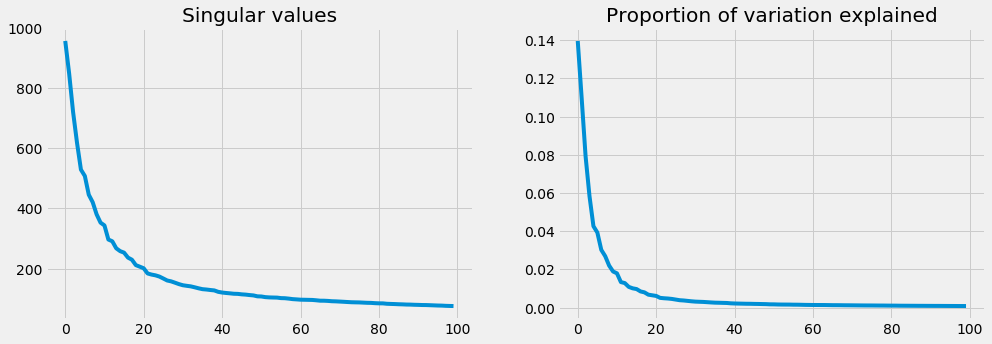

In [9]:
# Do PCA on the uncorrected data
uncorrected_means = np.mean(expression_uncorrected, axis = 0)
uncorrected_sds = np.std(expression_uncorrected, axis = 0)

y_uncorrected = (expression_uncorrected - uncorrected_means) / uncorrected_sds

pca_uncorrected = PCA(n_components=100)
pca_uncorrected.fit(y_uncorrected.T)
uncorrected_comps = pca_uncorrected.components_

# Let's look at the singular values and proportion of variation explained.
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(pca_uncorrected.singular_values_)
plt.title('Singular values')

plt.subplot(122)
plt.plot(pca_uncorrected.explained_variance_ratio_)
plt.title('Proportion of variation explained')

plt.show()

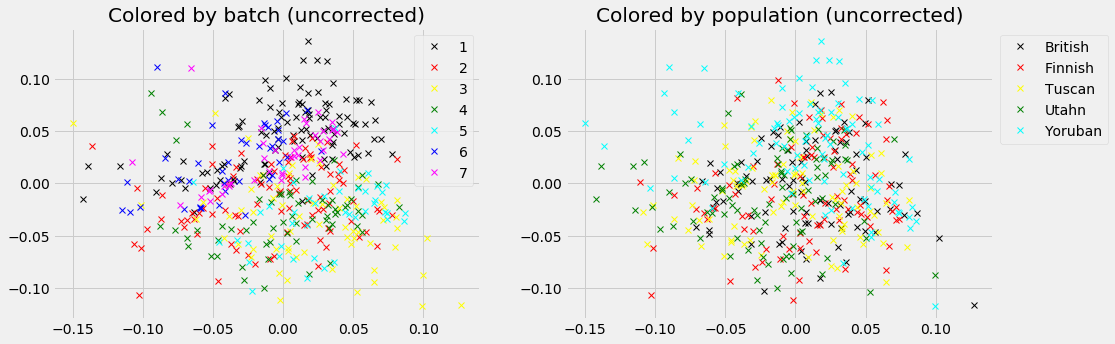

In [10]:
# Now let's look at the projections of our samples before correcting for any batch effects. 
# We'll color by both batch and population.

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==1], uncorrected_comps[1,metadata.iloc[2,:]==1], 'x', c = 'black')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==2], uncorrected_comps[1,metadata.iloc[2,:]==2], 'x', c = 'red')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==3], uncorrected_comps[1,metadata.iloc[2,:]==3], 'x', c = 'yellow')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==4], uncorrected_comps[1,metadata.iloc[2,:]==4], 'x', c = 'green')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==5], uncorrected_comps[1,metadata.iloc[2,:]==5], 'x', c = 'cyan')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==6], uncorrected_comps[1,metadata.iloc[2,:]==6], 'x', c = 'blue')
plt.plot(uncorrected_comps[0,metadata.iloc[2,:]==7], uncorrected_comps[1,metadata.iloc[2,:]==7], 'x', c = 'magenta')
plt.legend(['1', '2', '3', '4', '5', '6', '7'], loc = 'upper right', bbox_to_anchor = (1,1))
plt.title('Colored by batch (uncorrected)')

plt.subplot(122)
plt.plot(uncorrected_comps[0,metadata.iloc[3,:]=='British'], uncorrected_comps[1,metadata.iloc[3,:]=='British'], 'x', c = 'black')
plt.plot(uncorrected_comps[0,metadata.iloc[3,:]=='Finland'], uncorrected_comps[1,metadata.iloc[3,:]=='Finland'], 'x', c = 'red')
plt.plot(uncorrected_comps[0,metadata.iloc[3,:]=='Tuscan'], uncorrected_comps[1,metadata.iloc[3,:]=='Tuscan'], 'x', c = 'yellow')
plt.plot(uncorrected_comps[0,metadata.iloc[3,:]=='Utah'], uncorrected_comps[1,metadata.iloc[3,:]=='Utah'], 'x', c = 'green')
plt.plot(uncorrected_comps[0,metadata.iloc[3,:]=='Yoruba'], uncorrected_comps[1,metadata.iloc[3,:]=='Yoruba'], 'x', c = 'cyan')


plt.legend(['British', 'Finnish', 'Tuscan', 'Utahn', 'Yoruban'], loc = 'upper left', bbox_to_anchor = (1,1))
plt.title('Colored by population (uncorrected)')

plt.show()

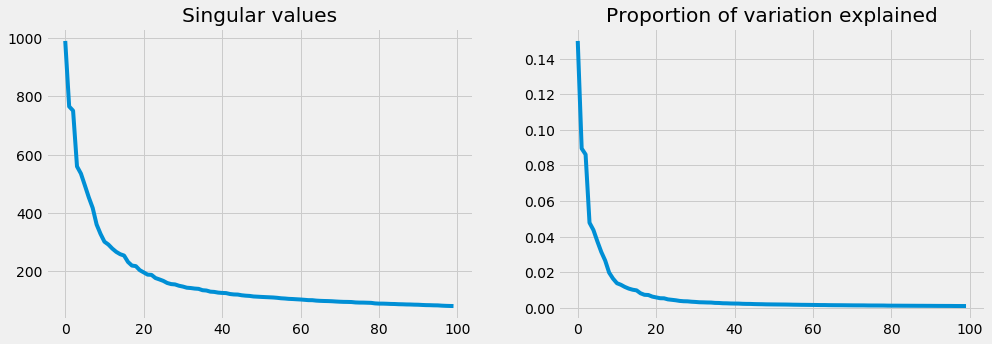

In [11]:
# Now let's repeat, but for the corrected data
corrected_means = np.mean(expression_corrected, axis = 0)
corrected_sds = np.std(expression_corrected, axis = 0)

y_corrected = (expression_corrected - corrected_means) / corrected_sds

pca_corrected = PCA(n_components=100)
pca_corrected.fit(y_corrected.T)  
corrected_comps = pca_corrected.components_

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(pca_corrected.singular_values_)
plt.title('Singular values')

plt.subplot(122)
plt.plot(pca_corrected.explained_variance_ratio_)
plt.title('Proportion of variation explained')

plt.show()

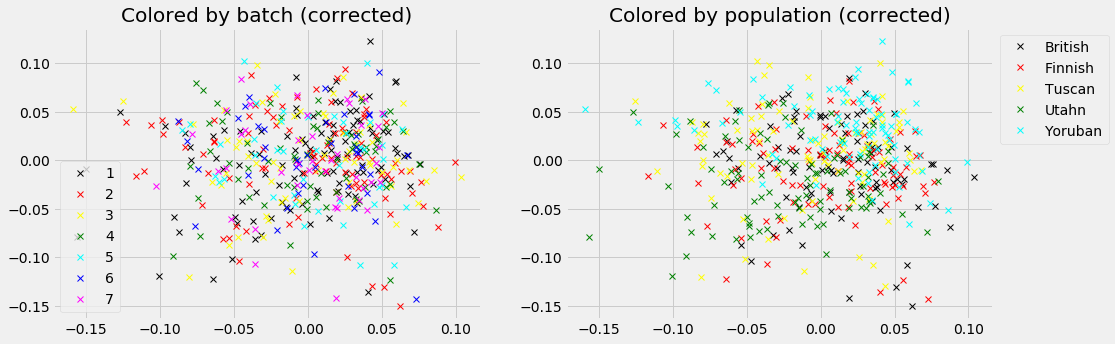

In [12]:
# Now look at the projections of the corrected data, again coloring by batch and population.
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(corrected_comps[0,metadata.iloc[2,:]==1], corrected_comps[1,metadata.iloc[2,:]==1], 'x', c = 'black')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==2], corrected_comps[1,metadata.iloc[2,:]==2], 'x', c = 'red')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==3], corrected_comps[1,metadata.iloc[2,:]==3], 'x', c = 'yellow')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==4], corrected_comps[1,metadata.iloc[2,:]==4], 'x', c = 'green')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==5], corrected_comps[1,metadata.iloc[2,:]==5], 'x', c = 'cyan')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==6], corrected_comps[1,metadata.iloc[2,:]==6], 'x', c = 'blue')
plt.plot(corrected_comps[0,metadata.iloc[2,:]==7], corrected_comps[1,metadata.iloc[2,:]==7], 'x', c = 'magenta')
plt.legend(['1', '2', '3', '4', '5', '6', '7'], loc = 'best')
plt.title('Colored by batch (corrected)')

plt.subplot(122)
plt.plot(corrected_comps[0,metadata.iloc[3,:]=='British'], corrected_comps[1,metadata.iloc[3,:]=='British'], 'x', c = 'black')
plt.plot(corrected_comps[0,metadata.iloc[3,:]=='Finland'], corrected_comps[1,metadata.iloc[3,:]=='Finland'], 'x', c = 'red')
plt.plot(corrected_comps[0,metadata.iloc[3,:]=='Tuscan'], corrected_comps[1,metadata.iloc[3,:]=='Tuscan'], 'x', c = 'yellow')
plt.plot(corrected_comps[0,metadata.iloc[3,:]=='Utah'], corrected_comps[1,metadata.iloc[3,:]=='Utah'], 'x', c = 'green')
plt.plot(corrected_comps[0,metadata.iloc[3,:]=='Yoruba'], corrected_comps[1,metadata.iloc[3,:]=='Yoruba'], 'x', c = 'cyan')


plt.legend(['British', 'Finnish', 'Tuscan', 'Utahn', 'Yoruban'], loc = 'upper left', bbox_to_anchor = (1,1))
plt.title('Colored by population (corrected)')

plt.show()

## Questions for this section

### B1. Compare the plots colored by batch before and after correction. Do you think PCA was able to demonstrate the presence of batch effects? Why or why not?

Yes, samples from the same batch tend to be near one another prior to the correction, whereas after there is no discernable pattern.

### B2. Which populations, if any, seem to be most distinguishable from the others on the basis of gene expression? Does this make sense?

The Yorubans seem to be somewhat clustered together if we color by the population label, though it would have been impossible to identify them without those a priori labels.

### B3. Does it seem easier to separate populations via PCA using genotype or gene expression data?

Genotype data for sure.

### B4. Why do you think the RNA-seq reads were normalized and log-transformed prior to performing PCA?

To make comparisons across individuals, we need to normalize or else technical factors will probably be a large source of variation. The log transformation makes the data nicer for standardization as well as numerical reasons.

### B5. By comparing the shapes of the variation explained plots for the genotype and RNA-seq data, which data set do you think was easier to compress?

The genotype plot seems to fall off more sharply whereas that for the RNA-seq data is a more gradual decline. Thus the genotype data appears easier to compress to a small number of dimensions.

## Submit

In [13]:
# ok = Notebook('Lab06_PCA.ok')
# _ = ok.auth(inline=True)

In [14]:
# Submit the assignment.
# _ = ok.submit()